In [9]:
import sklearn
from sklearn.cluster import MiniBatchKMeans
import sys
import tensorflow as tf
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, normalized_mutual_info_score
from keras.datasets import mnist

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K

In [4]:
(x_train, y_train),(x_test, y_test)=tf.keras.datasets.fashion_mnist.load_data()
x=np.concatenate((x_train, x_test))
y=np.concatenate((y_train, y_test))
print(x.shape)
x=x_train.reshape((x_train.shape[0],-1))
x=np.divide(x.astype(float),255)
kmeans = KMeans(n_clusters = 10)
kmeans.fit(x)

4431872/4422102 [==============================] - 0s 0us/step
(70000, 28, 28)


KMeans(n_clusters=10)

In [5]:
def infer_cluster_labels(kmeans, actual_labels):
    inferred_labels = {}
    for i in range(kmeans.n_clusters):
        labels = []
        index = np.where(kmeans.labels_ == i)
        labels.append(actual_labels[index])
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))
        if np.argmax(counts) in inferred_labels:
            inferred_labels[np.argmax(counts)].append(i)
        else:
            inferred_labels[np.argmax(counts)] = [i]      
    return inferred_labels  

In [6]:
def infer_data_labels(X_labels, cluster_labels):
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [7]:
n_clusters=10
cluster_labels = infer_cluster_labels(kmeans, y_train)
X_clusters = kmeans.predict(x)
predicted_labels = infer_data_labels(X_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[9 0 1 6 3 4 7 4 5 5 0 9 7 5 7 9 1 0 4 5]
[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


In [11]:
def calculate_metrics(estimator, data, labels):   
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Number of Clusters: {}'.format(estimator.n_clusters))

In [12]:
clusters = [10]
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(x)
    calculate_metrics(estimator, x, y_train)
    cluster_labels = infer_cluster_labels(estimator, y_train)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    print('KMeans Accuracy: {}\n'.format(metrics.accuracy_score(y_train, predicted_Y)))

Homogeneity: 0.4699382875722443
Inertia: 1984271.3511566161
Number of Clusters: 10
KMeans Accuracy: 0.49738333333333334



In [13]:
#Normalizing
x_train=x_train.reshape(-1,28,28,1)/255
x_test=x_test.reshape(-1,28,28,1)/255
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

In [16]:
#Auto Encoder using K-Means clustering
from keras.layers import Input, Dense
from keras.models import Model
model = Sequential()
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(7, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(14, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))
model.compile(optimizer="sgd", loss="mse", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 14)        140       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 14)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 14)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 7)         889       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 7)          0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 7)           0

In [18]:
history_AE=model.fit(x_train, x_train, epochs=5, batch_size=256, validation_data=(x_validate, x_validate), verbose=1)

Epoch 1/5
188/188 [==============================] - 71s 376ms/step - loss: 0.0677 - accuracy: 0.4930 - val_loss: 0.0594 - val_accuracy: 0.5017
Epoch 2/5
188/188 [==============================] - 69s 366ms/step - loss: 0.0580 - accuracy: 0.4960 - val_loss: 0.0590 - val_accuracy: 0.5019
Epoch 3/5
188/188 [==============================] - 70s 371ms/step - loss: 0.0551 - accuracy: 0.4973 - val_loss: 0.0582 - val_accuracy: 0.5020
Epoch 4/5
188/188 [==============================] - 72s 381ms/step - loss: 0.0533 - accuracy: 0.4980 - val_loss: 0.0574 - val_accuracy: 0.5021
Epoch 5/5
188/188 [==============================] - 72s 381ms/step - loss: 0.0519 - accuracy: 0.4984 - val_loss: 0.0565 - val_accuracy: 0.5022


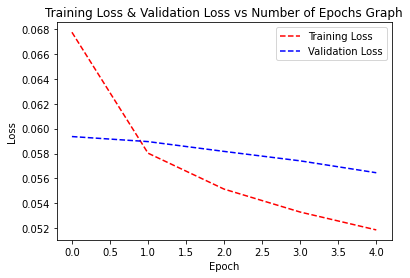

In [19]:
def lossPlot():
    trainingLoss,=plt.plot(history_AE.history['loss'],"r--")
    validationLoss,=plt.plot(history_AE.history['val_loss'],"b--")
    q=plt.legend([trainingLoss,validationLoss],["Training Loss","Validation Loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss & Validation Loss vs Number of Epochs Graph")
    plt.show()
lossPlot()